---
# HCP - Reward/loss network during Gambling

## Imports

In [1]:
import numpy as np
import nibabel as nb
# import nideconv as nd
import matplotlib.pyplot as plt
from nilearn.signal import clean
import nilearn
from scipy.interpolate import interp1d

ModuleNotFoundError: No module named 'nilearn'

In [2]:
nilearn.__version__

'0.7.0a'

In [3]:
who_dis = "jurjen"

if who_dis == "leo":
    HCP_DIR = '...'
elif who_dis == "lee":
    HCP_DIR = '...'
elif who_dis == "cliona":
    HCP_DIR = '...'
elif who_dis == 'frank':
    HCP_DIR = '...'
elif who_dis == 'johannes':
    HCP_DIR = '...'
elif who_dis == 'jurjen':
    HCP_DIR = '/data1/projects/MicroFunc/Jurjen/projects/NMA'

## Defaults

In [4]:
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

## Download data

In [5]:
# fname = "hcp_rest.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/bqp7m/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1
else:
    print('data already downloaded')

data already downloaded


In [7]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
else:
    print('atlas already downloaded')  

atlas already downloaded


In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

region_info.keys()

dict_keys(['name', 'network', 'myelin'])

In [9]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

## Load some functions

In [10]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

---
## Load data into dataframes

In [11]:
# This function should incorporate the things from the cells below it

def get_onset_times(subject, task="gambling", add_sec=None):

    """get_onset_times

  return a pandas dataframe from the onset files

  Args:
    subject     : int
                subject ID as specified in the HCP list

    task        : str
                task name you'd like to use

    """

    import pandas as pd
    import os
    opj = os.path.join


    for ii in ['LR', 'RL']:
      dname_onset = opj('hcp/subjects', str(subject), 'EVs', f'tfMRI_{task.upper()}_{ii}')
      win_onset = pd.read_csv(opj(dname_onset, 'win_event.txt'), delimiter='\t', header=None, names=['onset', 'duration', 'weighting'])
      loss_onset = pd.read_csv(opj(dname_onset, 'loss_event.txt'), delimiter='\t', header=None, names=['onset', 'duration', 'weighting'])

In [12]:
# Select some indices to extract ROIs
idx_roi = np.random.choice(len(region_info['name']), replace=False, size=10)

# Get the BOLD runs corresponding to Gambling task; returns [11,12]
run_nrs = get_image_ids("gambling")

In [132]:
def first_level(timecourses, onsets, threshold=2.3, TR=TR, rois=rois):

    """
    first_level

    Function to run a first level GLM anaylsis.

    Args:
        timecourses         : pd.DataFrame
                            timecourse dataframe as obtained with the load_subject_data function

        onsets              : pd.DataFrame
                            onsets dataframe as obtained with the load_subject_data function

        threshold           : float
                            threshold to fetch sig areas

        TR                  : float
                            repetition time

        rois                : list
                            parcel names

    Returns:
        sig_regions         : list
                            list containing the arrays with significant regions for each contrast

    """

    from nilearn.glm.first_level import make_first_level_design_matrix,run_glm
    from nilearn.glm.contrasts import compute_contrast

    onsets = onsets.reset_index()
    onsets_dropped = onsets.drop(columns=['subject', 'run'])
    onsets_dropped = onsets_dropped.rename(columns={'event_type':'trial_type'}, inplace=False)
    onsets_dropped['duration'] = 3.5

    timecourses = timecourses.values
    n_scans = timecourses.shape[0]
    frame_times = TR * (np.arange(n_scans))
    dm = make_first_level_design_matrix(frame_times, events=onsets_dropped, hrf_model='glover + derivative + dispersion')

    labels, estimates = run_glm(timecourses, dm.values)
    contrast_matrix = np.eye(dm.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                            for i, column in enumerate(dm.columns)])

    contrasts = {
        'win - loss': (
            basic_contrasts['win']
            - basic_contrasts['loss']
        ),
            'win - neut': (
            basic_contrasts['win']
            - basic_contrasts['neut']
        ),
            'loss - neut': (
            basic_contrasts['loss']
            - basic_contrasts['neut']
        )
    }

    all_stats = []
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # print('  Contrast % i out of %i: %s' %
        #     (index + 1, len(contrasts), contrast_id))
        # compute contrast-related statistics
        contrast = compute_contrast(labels, estimates, contrast_val,
                                    contrast_type='t')
        # we present the Z-transform of the t map
        z_score = contrast.z_score()
        all_stats.append(z_score)

    x = np.arange(len(rois))
    sig_regions = []
    for ii in range(len(all_stats)):
        idc = np.squeeze(np.argwhere(all_stats[ii] > thres))
        regions = np.array(rois)[idc]
        sig_regions.append(regions)

    return sig_regions

In [165]:
def plot_hrf(hrf):

    """
    plot_hrf

    simple function to display the HRF

    Args:
        hrf timecourse

    Returns:
        plt.figure

    """

    import numpy as np
    import matplotlib.pyplot as plt

    t = np.arange(0,hrf.size)
    fig,ax = plt.subplots(1, figsize=(12,5))
    ax.plot(t,hrf)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax

In [347]:
opj = os.path.join

task = "gambling"

# do it for one subject; but ideally we want all subjects in 1 dataframe
subject = '0'

def load_subject_data(subject, standardize=False, run=None):

    """load_subject_data

    returns dataframes with onsets times and data

    """

    # initiate some arrays to convert to pandas dataframe
    loss = []
    win = []
    onsets = []
    data_zscore = []
    sig_regions = []
    # nr_events = {}

    if not run:
        do_stuff = ['RL', 'LR']
    elif run == 1:
        do_stuff = ['RL']
    elif run == 2:
        do_stuff = ['LR']

    for idx,ii in enumerate(do_stuff):

        #############################################################################################3
        # Timing stuff
        dname_onset = opj(HCP_DIR, 'subjects', str(subject), 'EVs', f'tfMRI_{task.upper()}_{ii}')
        dname_timecourse = opj(HCP_DIR, 'subjects', str(subject), 'timeseries')

        # load onset times
        # print(f"Loading: {opj(dname_onset, 'win_event.txt')}")
        win_times = np.loadtxt(opj(dname_onset, 'win_event.txt'))[:,0][...,np.newaxis]
        loss_times = np.loadtxt(opj(dname_onset, 'loss_event.txt'))[:,0][...,np.newaxis]
        neut_times = np.loadtxt(opj(dname_onset, 'neut_event.txt'))[:,0][...,np.newaxis]

        # get win/loss in one array
        both_times = np.concatenate((win_times, loss_times, neut_times))

        # sort based on onset time and make dataframe
        arr = pd.DataFrame(sorted(np.squeeze(both_times)), columns=['onsets'])

        # fetch event_type based on presence of onset time in either win_times/loss_times array
        condition = []
        for ii in arr['onsets']:
            if ii in win_times:
                condition.append('win')
            elif ii in loss_times:
                condition.append('loss')
            elif ii in neut_times:
                condition.append('neut')

        # make a dataframe; otherwise later concatenation will mess with the float-status of onset times
        condition = pd.DataFrame(condition, columns=['event_type'])

        # concatenate onset times and condition dataframe
        all = np.concatenate((arr, condition), axis=1)

        # assert float again..
        all[:,0] = all[:,0].astype(float)

        # make the actual dataframe
        mixed_onsets = pd.DataFrame(all, columns=['onset', 'event_type'])

        # add some information for indexing
        mixed_onsets['subject'], mixed_onsets['run'] = 1, idx+1

        # append dataframe to initialized onsets list
        onsets.append(mixed_onsets)

        #############################################################################################3
        # Timecourse stuff

        # load timecourses, but one of the selected rois
        tc = np.load(opj(dname_timecourse, f'bold{run_nrs[idx]}_Atlas_MSMAll_Glasser360Cortical.npy')) #[idx_roi, :]
        
        # convert to zscore with nilearn.signal.clean
        if standardize:
            zscore = clean(tc, standardize='zscore')
        else:
            zscore = tc

        # create dataframe of timecourses; with rois as columns
        mixed_zscore = pd.DataFrame(zscore.T, columns=list(np.array(region_info['name']))) #[idx_roi]))

        # add some information for indexing
        mixed_zscore['subject'], mixed_zscore['run'], mixed_zscore['t'] = 1, idx+1, list(TR*np.arange(zscore.shape[-1]))

        # append dataframe to initialized data_zscore list
        data_zscore.append(mixed_zscore)

    # concatenate onsets and data_zscore lists to get indexed dataframes for onsets and timecourses
    onsets = pd.concat(onsets).set_index(['subject', 'run', 'event_type']).astype(float)
    data_zscore = pd.concat(data_zscore).set_index(['subject', 'run', 't'])

    # spit out onset array for RL
    labels = []
    tmp = onsets.reset_index()
    for rr,ii in enumerate(tmp['onset']):
        if tmp['event_type'][rr] == 'win':
            labels.append('W')
        elif tmp['event_type'][rr] == 'loss':
            labels.append('L')
        elif tmp['event_type'][rr] == 'neut':
            labels.append('N')

    # win = 2; loss = 0; neut = 1
    labels_num = (np.unique(labels, return_inverse=True)[1])

    return onsets,data_zscore,labels_num #,dict{'win': win_times, 'loss': loss_times, 'neut': neut_times}

In [312]:
times, fmri, _ = load_subject_data(0, standardize=True, run=1)

t = np.arange(0,fmri.shape[0])

random_stimulus_onsets = [int(i) for idx,i in enumerate(times.reset_index()['onset']) if times.reset_index()['event_type'][idx]=='win']

print(fmri.shape[0]*TR)
times

182.16


onset
subject run event_type         
1       1   win           8.063
            win          11.688
            loss         15.300
            win          18.899
            win          22.511
            win          26.123
            neut         29.721
            win          33.333
            win          51.939
            loss         55.537
            loss         59.136
            loss         62.748
            neut         66.360
            loss         69.972
            loss         73.583
            loss         77.195
            loss         95.801
            loss         99.400
            loss        102.998
            neut        106.610
            loss        110.222
            neut        113.834
            loss        117.446
            loss        121.058
            win         139.663
            win         143.275
            loss        146.874
            win         150.486
            loss        154.097
            win         157.696
            win         161.295
            win         164.906

In [425]:
def make_stimulus_vector(onset_df, scan_length=None, TR=0.72, osf=None):

    """
    make_stimulus_vector

    create a np.1darray for a given condition with the length of number of scans

    """

    from scipy.interpolate import interp1d
    import numpy as np

    Y1 = np.zeros(int((scan_length*TR)*osf))
    Y2 = np.zeros(int((scan_length*TR)*osf))

    try:
        onset_df = onset_df.reset_index()
    except:
        onset_df = onset_df

    for rr,ii in enumerate(onset_df['onset']):
        if onset_df['event_type'][rr] == 'win':
            Y1[int(ii*osf)] = 1
        elif onset_df['event_type'][rr] == 'loss':
            Y2[int(ii*osf)] = 1

    # original_scale = np.arange(0, int(scan_length*TR), 1)
    # desired_scale = np.arange(0, int(scan_length*TR), TR)

    # resampler1 = interp1d(original_scale, np.squeeze(Y1), kind='nearest', fill_value='extrapolate')
    # resampler2 = interp1d(original_scale, np.squeeze(Y2), kind='nearest', fill_value='extrapolate')

    # Y1_ds = resampler1(desired_scale)[..., np.newaxis]
    # Y2_ds = resampler2(desired_scale)[..., np.newaxis]

    return np.squeeze(Y1),np.squeeze(Y2)

In [426]:
osf = 1000
v_win,v_loss = make_stimulus_vector(times, scan_length=fmri.shape[0], osf=osf)

v_win.shape

(182160,)

In [427]:
def double_gamma(x, lag=6, a2=12, b1=0.9, b2=0.9, c=0.35, scale=True):

    a1 = lag
    d1 = a1 * b1 
    d2 = a2 * b2 
    hrf = np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])
    
    if scale:
        hrf = (1 - hrf.min()) * (hrf - hrf.min()) / (hrf.max() - hrf.min()) + hrf.min()
    return hrf

dt = TR/osf
time_points = np.linspace(0,25,np.rint(float(25)/dt).astype(int))
canonical_hrf = double_gamma(time_points, lag=5)

<AxesSubplot:>

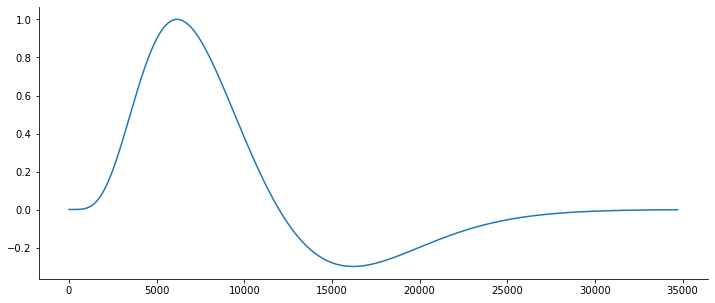

In [428]:
plot_hrf(canonical_hrf)

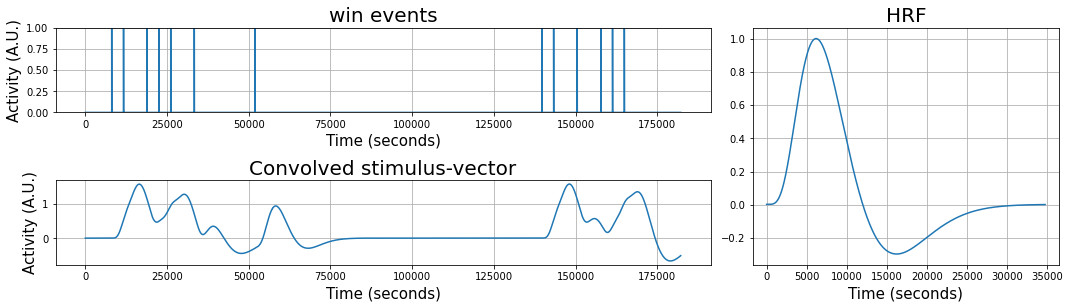

In [429]:
plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(v_win)
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('win events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
# plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector_win = np.convolve(v_win, canonical_hrf, 'full')[:v_win.shape[0]]
convolved_stim_vector_loss = np.convolve(v_loss, canonical_hrf, 'full')[:v_win.shape[0]]

plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector_win)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [430]:
TR*osf

720.0

In [431]:
original_scale = np.arange(0, len(convolved_stim_vector_loss), 1)
desired_scale = np.arange(0, len(convolved_stim_vector_loss), int(TR*osf))

print(original_scale.shape)
print(desired_scale.shape)

resampler1 = interp1d(original_scale, np.squeeze(convolved_stim_vector_win), kind='nearest')
resampler2 = interp1d(original_scale, np.squeeze(convolved_stim_vector_loss), kind='nearest')

convolved_stim_vector_win = resampler1(desired_scale)[..., np.newaxis]
convolved_stim_vector_loss = resampler2(desired_scale)[..., np.newaxis]

print(convolved_stim_vector_loss[:50])

(182160,)
(253,)
[[ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.003]
 [ 0.02 ]
 [ 0.1  ]
 [ 0.262]
 [ 0.478]
 [ 0.697]
 [ 0.872]
 [ 0.975]
 [ 0.999]
 [ 0.952]
 [ 0.852]
 [ 0.715]
 [ 0.561]
 [ 0.402]
 [ 0.249]
 [ 0.11 ]
 [-0.01 ]
 [-0.109]
 [-0.185]
 [-0.24 ]
 [-0.275]
 [-0.293]
 [-0.296]
 [-0.288]
 [-0.272]
 [-0.249]
 [-0.224]
 [-0.197]]


(253,)


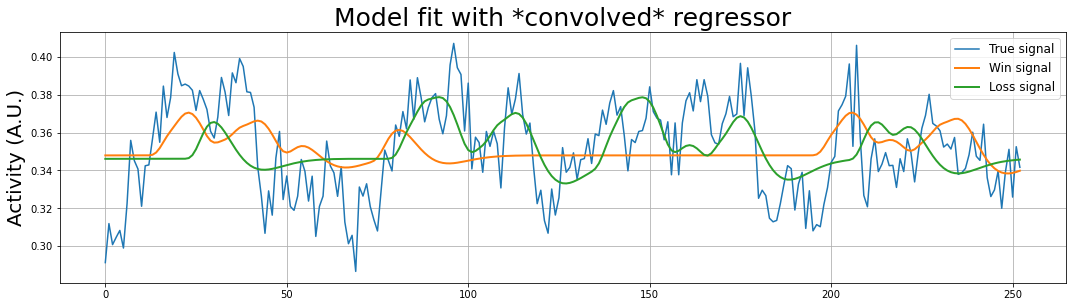

In [432]:
if convolved_stim_vector_win.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    convolved_stim_vector_win = convolved_stim_vector_win[:, np.newaxis]

if convolved_stim_vector_loss.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    convolved_stim_vector_loss = convolved_stim_vector_loss[:, np.newaxis]    

from numpy.linalg import inv

voxel_signal = fmri.values[:,5]

intercept = np.ones((convolved_stim_vector_win.size, 1))
X_conv_win = np.hstack((intercept, convolved_stim_vector_win))
X_conv_loss = np.hstack((intercept, convolved_stim_vector_loss))

print(voxel_signal.shape)

betas_conv_win = inv(X_conv_win.T @ X_conv_win) @ X_conv_win.T @ voxel_signal
betas_conv_loss = inv(X_conv_loss.T @ X_conv_loss) @ X_conv_loss.T @ voxel_signal

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv_win @ betas_conv_win, lw=2)
plt.plot(X_conv_loss @ betas_conv_loss, lw=2)
# plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Win signal', 'Loss signal'], fontsize=12, loc='upper right')
plt.grid()

plt.tight_layout()
plt.show()

In [433]:
print(f'betas win: {betas_conv_win}')
print(f'betas loss: {betas_conv_loss}')

betas win: [0.348 0.014]
betas loss: [0.346 0.019]


In [140]:
def convolve_connectivity():

    """
    convolve_connectivity

    Fit a model to the connectivity over time

    Args:
        dfc     : np.array
                numpy array containing the dynamic FC of a subject

        onsets  : pd.DataFrame
                onsets dataframe as obtained with the load_subject_data function

    Returns:
        measures of model fit. 

    """

    from nilearn.glm.first_level.hemodynamic_models import glover_hrf

    TR = 0.72
    osf = 2
    length_hrf = 20

    canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
    canonical_hrf /= canonical_hrf.max()

    return canonical_hrf

---
# Functional Connectivity

In [124]:
load_subject_data(0, run=1)

0.72
(253, 13)


(                          onset
 subject run event_type         
 1       1   win           8.063
             win          11.688
             loss         15.300
             win          18.899
             win          22.511
             win          26.123
             neut         29.721
             win          33.333
             win          51.939
             loss         55.537
             loss         59.136
             loss         62.748
             neut         66.360
             loss         69.972
             loss         73.583
             loss         77.195
             loss         95.801
             loss         99.400
             loss        102.998
             neut        106.610
             loss        110.222
             neut        113.834
             loss        117.446
             loss        121.058
             win         139.663
             win         143.275
             loss        146.874
             win         150.486
          

In [15]:
data = []
for ii in subjects:
    ts = load_subject_data(ii, standardize=True, run=1)[1].values.T
    data.append(ts)

In [16]:
ts.shape

(360, 253)

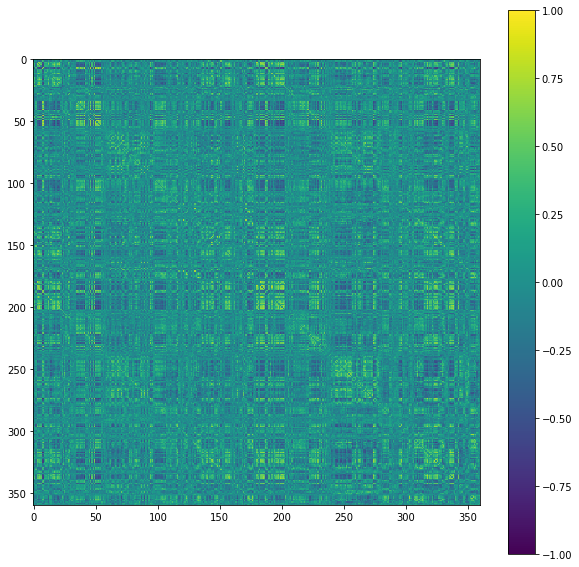

In [20]:
fc = np.zeros((len(data), N_PARCELS, N_PARCELS))
for sub, ts in enumerate(data):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

np.fill_diagonal(group_fc, 0)

plt.figure(figsize=(10,10))
plt.imshow(group_fc, interpolation="none", cmap="viridis", vmin=-1, vmax=1)
ticks = range(0,N_PARCELS)
plt.xticks = (ticks, region_info['name'])
plt.colorbar()
plt.show()

In [17]:
def DFC(timeseries, window_tr=50, stop_tr=15, step_size=1):

    """
    DFC

    Function to obtain the functional connectivity matrices over time.

    Args:
        timeseries      : np.ndarray
                        a PARCEL x TIMEPOINTS array

        window_tr       : int
                        window size to use

        stop_tr         : int
                        break the loop if there's only <stop_tr> amount 
                        of timepoints being fed into the correlation

        step_size       : int
                        size of the steps the window is taking

    Returns:

        TIMEPOINTS X PARCEL X PARCEL numpy array

    """

    from nilearn.connectome import ConnectivityMeasure
    import numpy as np

    # start with step 0
    step = 0

    # initialize list to store all our FC-matrices in
    FC = []

    # start while loop
    do_stuff = True
    while do_stuff:

        # do this until we can't get 50 TRs in anymore
        try:
            timecourse = timeseries[:,step:step+window_tr]
        except:
            timecourse = timeseries[:,:step]

        if timecourse.shape[-1] == stop_tr:
            break
        
        # get the correlation matrix
        correlation_measure = ConnectivityMeasure(kind='correlation')


        correlation_matrix = correlation_measure.fit_transform([timecourse.T])[0]

        # include onsets here > get variance for reward/loss

        FC.append(correlation_matrix)

        step += step_size

    return np.array(FC)

In [22]:
FC1 = DFC(ts)
print(FC1.shape)

(238, 360, 360)


In [29]:
# data = []
# RL = []
# for ii in subjects:
#     ts = load_subject_data(ii, standardize=True, run=1)[1].values.T
#     data.append(DFC(ts))

#     RL.append(load_subject_data(ii, standardize=True, run=1)[2])

# data = np.array(data)
# RL = np.array(RL)

# print(data.shape)

In [342]:
RL = []
for ii in subjects:
    RL.append(load_subject_data(ii, standardize=True, run=1)[2])

RL = np.array(RL)
# np.save(opj(HCP_DIR, 'RL.npy'), RL)

tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/147/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/148/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/149/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/150/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/151/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/152/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/153/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/154/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFunc/Jurjen/projects/NMA/subjects/155/EVs/tfMRI_GAMBLING_RL/win_event.txt
Loading: /data1/projects/MicroFu

In [334]:
sig_regions = []
RL = []
for ii in subjects:
    onsets,data,num_onsets = load_subject_data(ii, standardize=True, run=1)
    RL.append(num_onsets)

    # run first level GLM
    sig_regions.append(first_level(data, onsets))

In [339]:
print(RL[0], '\n',RL[60])

[2 2 0 2 2 2 1 2 2 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 2 2 0 2 0 2 2 2] 
 [2 2 0 2 2 2 1 2 2 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 2 2 0 2 0 2 2 2]


In [133]:
sig_regions[0]

[array(['R_4', 'R_8BL', 'R_9p', 'R_11l', 'R_STGa', 'R_TE2a', 'R_A4',
        'R_TE1m', 'L_31pv', 'L_8Av', 'L_8BL', 'L_8C', 'L_IFSp', 'L_s6-8',
        'L_Pir', 'L_TE1a', 'L_TE1p', 'L_TE2a', 'L_LBelt', 'L_A4'],
       dtype='<U8'),
 array(['R_SFL', 'R_6ma', 'R_d32', 'R_11l', 'L_V8', 'L_LIPv', 'L_p24pr',
        'L_a10p', 'L_MI', 'L_FOP5', 'L_TGv'], dtype='<U8'),
 array(['R_SFL', 'L_V8', 'L_p24pr', 'L_a10p', 'L_MI', 'L_TPOJ2', 'L_VMV3',
        'L_FOP5'], dtype='<U8')]

In [21]:
FC_mean = data.mean(axis=0)
FC_mean.shape

NameError: name 'data' is not defined

In [25]:
static_FC = FC_mean.mean(axis=0)
print(static_FC.shape)

(360, 360)


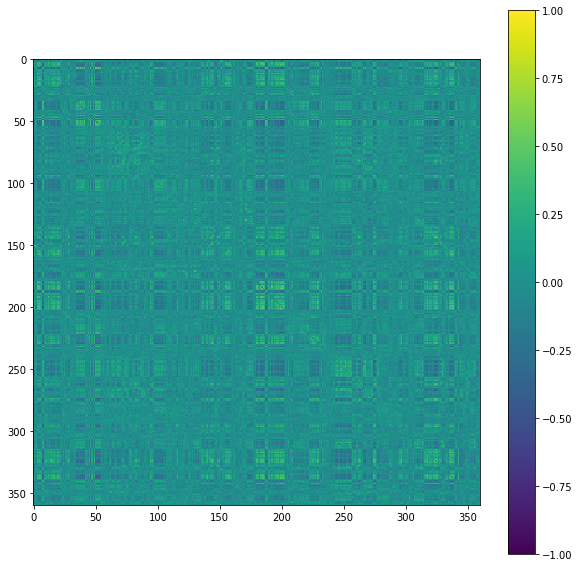

In [90]:
np.fill_diagonal(static_FC, 0)

plt.figure(figsize=(10,10))
plt.imshow(static_FC, interpolation="none", cmap="viridis", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

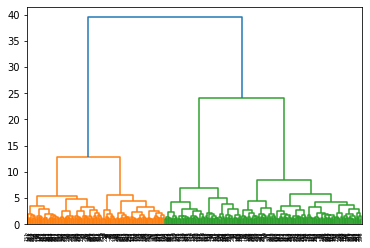

In [86]:
import scipy.cluster.hierarchy as sch
dend = sch.dendrogram(sch.linkage(static_FC, method='ward'))

In [109]:
new_idx = list(np.array(dend['ivl']).astype(int))

In [111]:
clustered_FC = pd.DataFrame(static_FC, columns=[i for i in range(360)])
clustered_FC = clustered_FC.reindex(new_idx, columns=new_idx)
clustered_FC.head()

,151,2,141,215,218,209,212,44,216,220,...,57,165,334,357,228,182,331,208,26,206
151,0.000000,0.311675,0.181094,0.118973,0.170141,0.011960,0.068815,0.081724,0.068766,0.011542,...,0.022558,-0.003735,0.019839,0.001624,0.114645,0.207804,0.309617,0.007863,0.059622,-0.021902
2,0.311675,0.000000,0.234675,0.155531,0.114836,0.009853,0.016532,0.078812,0.076618,0.057582,...,0.035775,0.004084,0.047583,-0.011059,0.046410,0.159692,0.216084,-0.029921,0.010857,-0.070119
141,0.181094,0.234675,0.000000,0.109263,0.170974,-0.021742,0.045517,0.066169,0.013310,-0.060568,...,0.100060,0.027112,-0.015020,-0.014574,0.090318,0.051612,0.157939,0.011516,0.009777,-0.025007
215,0.118973,0.155531,0.109263,0.000000,0.312690,0.118312,0.063647,0.137655,0.159459,0.116126,...,0.039683,0.042554,0.113155,0.051920,0.046347,0.101798,0.115463,0.142993,0.113968,0.076785
218,0.170141,0.114836,0.170974,0.312690,0.000000,0.092134,0.026000,0.147232,0.190914,0.044235,...,0.079179,0.064238,0.143399,0.159511,0.132428,0.102520,0.195887,0.150606,0.069537,0.109976


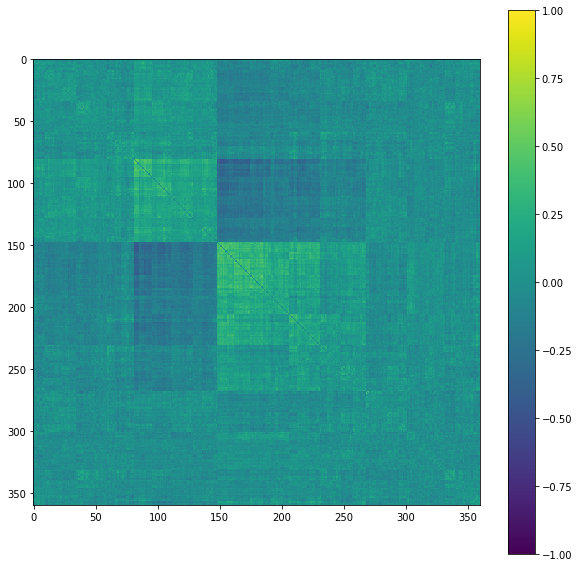

In [112]:
plt.figure(figsize=(10,10))
plt.imshow(clustered_FC, interpolation="none", cmap="viridis", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [19]:
# from linescanning.bin.utils.utils import format_graph
# import seaborn as sns

rois = region_info['name']
# idx1 = np.random.choice(len(rois), size=1)[0]
# idx2 = np.random.choice(len(rois), size=1)[0]

# print(f'\n{idx1}: {rois[idx1]}\nidx2: {rois[idx2]}')

# with plt.xkcd():
#     fig = plt.figure(figsize=(10,5))

#     g = fig.add_subplot(111)
#     g.plot(FC_mean[:,idx1,idx2])

#     format_graph(X='volumes', Y="pearson correlation", title=f'FC between {rois[idx1]} and {rois[idx2]}')

#     sns.despine(offset=10)

---
## Modelling

### Prepare 'Y'

In [28]:
# prepare X; n_samples x n_features
# n_features here is the connectivity over time between a pair of ROIs. Now these pairs are randomly selected.
n_features = 10

X = []
pairs = {}
for ii in range(n_features):
    idc = np.random.choice(len(rois), size=2)
    pairs[f'pair {ii}'] = [f'{rois[idc[0]]}', f'{rois[idc[1]]}', idc[0], idc[1]]
    X.append(FC_mean[:,idc[0],idc[1]])

X = np.array(X).T
X.shape

NameError: name 'FC_mean' is not defined

In [72]:
pairs

{'pair 0': ['L_a24', 'R_IFJp', 240, 79],
 'pair 1': ['L_A5', 'R_PFt', 304, 115],
 'pair 2': ['R_LIPv', 'L_a10p', 47, 268],
 'pair 3': ['L_10v', 'L_44', 267, 253],
 'pair 4': ['R_AVI', 'L_IP2', 110, 323],
 'pair 5': ['R_d32', 'L_PFm', 61, 328],
 'pair 6': ['L_SCEF', 'L_V4t', 222, 335],
 'pair 7': ['R_TPOJ1', 'R_TGv', 138, 171],
 'pair 8': ['L_TE1m', 'L_3b', 356, 188],
 'pair 9': ['L_52', 'L_TPOJ2', 282, 319]}

In [97]:
onsets = load_subject_data(0, standardize=True, run=1)[0] #.reset_index()
# onsets_dropped = onsets.drop(columns=['subject', 'run'])
# onsets_dropped = onsets_dropped.rename(columns={'event_type':'trial_type'}, inplace=False)
# onsets_dropped['duration'] = 3.5
# onsets_dropped.head()

In [47]:
from nilearn.glm.first_level import make_first_level_design_matrix,run_glm

n_scans = data[0].shape[-1]
frame_times = TR * (np.arange(n_scans))
dm = make_first_level_design_matrix(frame_times, events=onsets_dropped, hrf_model='glover + derivative + dispersion')
dm.head()

,loss,loss_derivative,loss_dispersion,neut,neut_derivative,neut_dispersion,win,win_derivative,win_dispersion,drift_1,drift_2,drift_3,constant
0.00,0.0,0.0,3.948518e-17,0.0,0.0,3.903015e-17,0.0,0.0,-1.676631e-16,0.088909,0.088904,0.088895,1.0
0.72,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.088895,0.088849,0.088772,1.0
1.44,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.088868,0.088740,0.088526,1.0
2.16,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.088827,0.088575,0.088156,1.0
2.88,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.088772,0.088356,0.087665,1.0


In [111]:
Y = load_subject_data(0, standardize=True, run=1)[1]
Y.values.shape

(253, 360)

In [126]:
kk = first_level(Y, onsets)
Y

0.72
(253, 13)


R_V1     R_MST      R_V6      R_V2      R_V3  \
subject run t                                                          
1       1   0.00    0.785829 -0.102569  1.136563  0.845774  0.521239   
            0.72    0.807842 -0.067051  1.141801  0.857453  0.541443   
            1.44    0.791541 -0.093479  1.133982  0.845683  0.534759   
            2.16    0.782046 -0.120571  1.122182  0.833372  0.532681   
            2.88    0.739217 -0.057776  1.116420  0.825460  0.522476   
...                      ...       ...       ...       ...       ...   
            178.56  0.795233 -0.089337  1.105201  0.838374  0.487819   
            179.28  0.817945 -0.133648  1.121844  0.854691  0.501515   
            180.00  0.820779 -0.075202  1.094241  0.851572  0.498422   
            180.72  0.799130 -0.098396  1.069043  0.851736  0.507251   
            181.44  0.789995 -0.081685  1.059492  0.838805  0.505678   

                        R_V4      R_V8       R_4      R_3b     R_FEF  ...  \
subject run t                                                         ...   
1       1   0.00    0.291349  0.123357 -1.326358 -1.168848 -1.001903  ...   
            0.72    0.311939  0.149436 -1.331323 -1.207235 -1.002024  ...   
            1.44    0.300832  0.074900 -1.337255 -1.204674 -1.017112  ...   
            2.16    0.304709  0.086827 -1.350085 -1.206137 -1.001584  ...   
            2.88    0.308327  0.066421 -1.329293 -1.220673 -1.020406  ...   
...                      ...       ...       ...       ...       ...  ...   
            178.56  0.339010  0.140470 -1.337248 -1.227510 -0.984712  ...   
            179.28  0.351150  0.120270 -1.326429 -1.204887 -0.990945  ...   
            180.00  0.325941  0.112111 -1.320192 -1.204436 -1.007795  ...   
            180.72  0.352535  0.160945 -1.337880 -1.200117 -1.031499  ...   
            181.44  0.341649  0.158481 -1.332895 -1.201366 -0.982993  ...   

                      L_p47r     L_TGv   L_MBelt   L_LBelt      L_A4  \
subject run t                                                          
1       1   0.00    0.708241 -0.548369 -0.342023 -0.391105 -0.752668   
            0.72    0.690034 -0.583156 -0.308705 -0.332229 -0.772313   
            1.44    0.683394 -0.577794 -0.338894 -0.347519 -0.763726   
            2.16    0.703103 -0.536371 -0.333693 -0.362496 -0.788825   
            2.88    0.685873 -0.576349 -0.295777 -0.352116 -0.795412   
...                      ...       ...       ...       ...       ...   
            178.56  0.728751 -0.581434 -0.270573 -0.219457 -0.698627   
            179.28  0.760598 -0.557036 -0.259027 -0.187359 -0.701573   
            180.00  0.736081 -0.553156 -0.322866 -0.235678 -0.707631   
            180.72  0.711719 -0.590509 -0.279459 -0.229082 -0.748193   
            181.44  0.685285 -0.560877 -0.219897 -0.248716 -0.711053   

                     L_STSva    L_TE1m      L_PI   L_a32pr     L_p24  
subject run t                                                         
1       1   0.00    0.261996 -2.608281  0.694006  1.498373  1.690113  
            0.72    0.313011 -2.576066  0.684799  1.532446  1.661717  
            1.44    0.326007 -2.578045  0.711152  1.519221  1.707529  
            2.16    0.309171 -2.564010  0.726504  1.580470  1.638834  
            2.88    0.289799 -2.575408  0.796996  1.566139  1.652595  
...                      ...       ...       ...       ...       ...  
            178.56  0.355434 -2.543497  0.699809  1.546399  1.722051  
            179.28  0.381644 -2.547590  0.720878  1.581938  1.668080  
            180.00  0.372927 -2.552290  0.697195  1.541421  1.669254  
            180.72  0.393064 -2.523874  0.753047  1.531848  1.686033  
            181.44  0.362198 -2.518043  0.727160  1.604007  1.745164  

[253 rows x 360 columns]

In [55]:
labels, estimates = run_glm(Y, dm.values)

contrast_matrix = np.eye(dm.shape[1])

basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(dm.columns)])

print(basic_contrasts)

contrasts = {
    'win - loss': (
        basic_contrasts['win']
        - basic_contrasts['loss']
    ),
        'win - neut': (
        basic_contrasts['win']
        - basic_contrasts['neut']
    ),
        'loss - neut': (
        basic_contrasts['loss']
        - basic_contrasts['neut']
    )
}

{'loss': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'loss_derivative': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'loss_dispersion': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'neut': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'neut_derivative': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'neut_dispersion': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'win': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'win_derivative': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'win_dispersion': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'drift_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'drift_2': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'drift_3': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'constant': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


In [92]:
sig_regions

[array(['R_4', 'R_8BL', 'R_9p', 'R_11l', 'R_STGa', 'R_TE2a', 'R_A4',
        'R_TE1m', 'L_31pv', 'L_8Av', 'L_8BL', 'L_8C', 'L_IFSp', 'L_s6-8',
        'L_Pir', 'L_TE1a', 'L_TE1p', 'L_TE2a', 'L_LBelt', 'L_A4'],
       dtype='<U8'),
 array(['R_SFL', 'R_6ma', 'R_d32', 'R_11l', 'L_V8', 'L_LIPv', 'L_p24pr',
        'L_a10p', 'L_MI', 'L_FOP5', 'L_TGv'], dtype='<U8'),
 array(['R_SFL', 'L_V8', 'L_p24pr', 'L_a10p', 'L_MI', 'L_TPOJ2', 'L_VMV3',
        'L_FOP5'], dtype='<U8')]

In [56]:
from nilearn.glm.contrasts import compute_contrast
from nilearn import plotting

all_stats = []
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    all_stats.append(z_score)

  Contrast  1 out of 3: win - loss
  Contrast  2 out of 3: win - neut
  Contrast  3 out of 3: loss - neut


regions z>2.3 in c0: ['R_4', 'R_8BL', 'R_9p', 'R_11l', 'R_STGa', 'R_TE2a', 'R_A4', 'R_TE1m', 'L_31pv', 'L_8Av', 'L_8BL', 'L_8C', 'L_IFSp', 'L_s6-8', 'L_Pir', 'L_TE1a', 'L_TE1p', 'L_TE2a', 'L_LBelt', 'L_A4']
regions z>2.3 in c1: ['R_SFL', 'R_6ma', 'R_d32', 'R_11l', 'L_V8', 'L_LIPv', 'L_p24pr', 'L_a10p', 'L_MI', 'L_FOP5', 'L_TGv']
regions z>2.3 in c2: ['R_SFL', 'L_V8', 'L_p24pr', 'L_a10p', 'L_MI', 'L_TPOJ2', 'L_VMV3', 'L_FOP5']


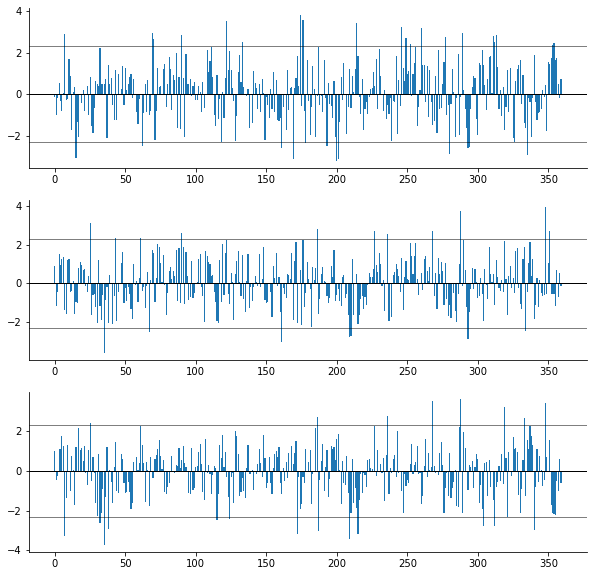

In [134]:
fig,axs = plt.subplots(len(all_stats), figsize=(10,10))
thres = 2.3
x = np.arange(len(rois))
sig_regions = []
for ii in range(len(all_stats)):

    axs[ii].bar(x, all_stats[ii])
    axs[ii].spines['top'].set_visible(False)
    axs[ii].spines['right'].set_visible(False)
    axs[ii].axhline(-2.3, color='k', lw=0.5)
    axs[ii].axhline(2.3, color='k', lw=0.5)
    axs[ii].axhline(0, color='k', lw=1)

    idc = np.squeeze(np.argwhere(all_stats[ii] > thres))

    regions = np.array(rois)[idc]
    sig_regions.append(regions)
    print(f'regions z>{thres} in c{ii}: {[i for i in regions]}')

    

In [85]:
np.array(rois)[idc]

array(['R_4', 'R_8BL', 'R_9p', 'R_11l', 'R_STGa', 'R_TE2a', 'R_A4',
       'R_TE1m', 'L_31pv', 'L_8Av', 'L_8BL', 'L_8C', 'L_IFSp', 'L_s6-8',
       'L_Pir', 'L_TE1a', 'L_TE1p', 'L_TE2a', 'L_LBelt', 'L_A4'],
      dtype='<U8')

In [31]:
range(X.shape[0])

range(0, 238)

### Vectorize onsets to create 'X'

In [25]:
onsets = load_subject_data(0, standardize=True, run=1)[0].reset_index()

Y1 = np.zeros((int(X.shape[0]*TR),1))
Y2 = np.zeros((int(X.shape[0]*TR),1))
Y3 = np.zeros((int(X.shape[0]*TR),1))

labels = []

for rr,ii in enumerate(onsets['onset']):
    if onsets['event_type'][rr] == 'win':
        Y1[int(ii)] = 1
        Y3[int(ii)] = 1
        labels.append('W')
    elif onsets['event_type'][rr] == 'loss':
        Y2[int(ii)] = 1
        Y3[int(ii)] = 2
        labels.append('L')

original_scale = np.arange(0, int(X.shape[0]*TR), 1)
desired_scale = np.arange(0, int(X.shape[0]*TR), TR)

print(original_scale.shape)
print(desired_scale.shape)
print(np.squeeze(Y1).shape)

from scipy.interpolate import interp1d
resampler1 = interp1d(original_scale, np.squeeze(Y1), kind='nearest', fill_value='extrapolate')
resampler2 = interp1d(original_scale, np.squeeze(Y2), kind='nearest', fill_value='extrapolate')
resampler3 = interp1d(original_scale, np.squeeze(Y3), kind='nearest', fill_value='extrapolate')

Y1_ds = resampler1(desired_scale)[..., np.newaxis]
Y2_ds = resampler2(desired_scale)[..., np.newaxis]
Y3_ds = resampler3(desired_scale)[..., np.newaxis]

Y = np.hstack((Y1_ds,Y2_ds))
Y = np.squeeze(Y3_ds)

print(Y)

labels_num = (np.unique(labels, return_inverse=True)[1])
labels_num

NameError: name 'X' is not defined

In [44]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# lab_enc = LabelEncoder()
# lab_enc.fit(labels)
# print(lab_enc.classes_)

# Y = lab_enc.transform(labels)
# scaler = StandardScaler()

# print(Y)

['L' 'W']
[1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1]


### Logistic Regression?

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression()
log_reg.fit(X, Y)
y_pred = log_reg.predict(X)

accuracies = cross_val_score(LogisticRegression(), X, Y, cv=8) # k=8 crossvalidation

[[], Text(0.5, 0, 'Accuracy'), Text(0.5, 1.0, 'Average test accuracy: 84.51%')]

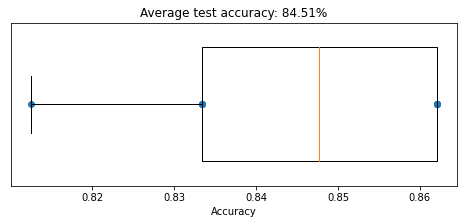

In [61]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)